# Бифуркации $I_{Na,p}+I_K$ модели и интерактивные графики на фазовой плоскости

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from __future__ import division

In [3]:
import bokeh
import bokeh.plotting as bp
from bokeh.models import ColumnDataSource, Range1d

from ipywidgets import interact

In [4]:
bp.output_notebook()


Loading BokehJS ...

In [5]:
import PyDSTool as dst
from PyDSTool.Toolbox import phaseplane as pp

## Модель $I_{Na,p}+I_K$

\begin{equation}
C\dot{V} = I - (\bar{g}_Kn(V-E_K) + \bar{g}_{Na}m_\infty(V)(V-E_{Na}) + gl(V-El))
\end{equation}

\begin{equation}
\tau_n n = (n_\infty(V) - n)
\end{equation}

\begin{equation}
x_\infty =  \frac{1}{1 + \exp(\frac{V_{1/2}-V}{k})}
\end{equation}

In [2]:
napk_pset = dict(
    I = 0.0,
    El = -80.0,
    Ena = 60.0,
    Ek = -90.0,
    gl = 8.0,
    gna = 20.0,
    gk = 10.0,
    ntau = 5.0,
    minf_vhalf = -20.,
    minfk = 15.,
    ninf_vhalf = -25.,
    ninfk = 5.0
)

In [7]:
pset_str = ';\n'.join(['{k}=dst.Par({v},"{k}")'.format(k=k,v=v) for k,v in napk_pset.items()])
print pset_str
exec(pset_str)

ntau=dst.Par(1.0,"ntau");
Ena=dst.Par(60.0,"Ena");
Ek=dst.Par(-90.0,"Ek");
El=dst.Par(-80.0,"El");
I=dst.Par(0.0,"I");
minf_vhalf=dst.Par(-20.0,"minf_vhalf");
ninf_vhalf=dst.Par(-25.0,"ninf_vhalf");
minfk=dst.Par(15.0,"minfk");
gna=dst.Par(20.0,"gna");
ninfk=dst.Par(5.0,"ninfk");
gl=dst.Par(8.0,"gl");
gk=dst.Par(10.0,"gk")


In [8]:
V = dst.Var('V')
n = dst.Var('n')

In [9]:
boltzman = dst.Fun(1./(1. + dst.Exp(('Vhalf'- V)/'bk')), ['Vhalf','bk'], 'boltzman')
minf = boltzman(minf_vhalf,minfk)
ninf = boltzman(ninf_vhalf,ninfk)

In [10]:
print minf
print 'At -10 mV:', minf.eval(V=-10)

1.0/(1.0+Exp((minf_vhalf-V)/minfk))
At -10 mV: 1.0/(1.0+Exp((minf_vhalf+10)/minfk))


In [11]:
vtest = linspace(-89, 45, 250)

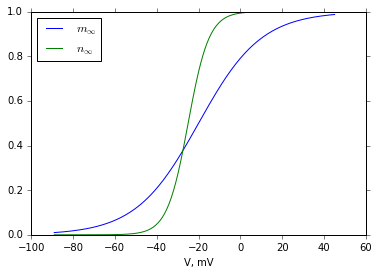

In [12]:
plot(vtest, eval(str(minf.eval(V='vtest', Exp='np.exp', **napk_pset))))
plot(vtest, eval(str(ninf.eval(V='vtest', Exp='np.exp',**napk_pset))))
xlabel(u'V, mV'); legend(('$m_\infty$', '$n_\infty$'),loc='best')

In [13]:
dn = (ninf-n)/ntau

In [14]:
print dn

((1.0/(1.0+Exp((ninf_vhalf-V)/ninfk)))-n)/ntau


In [15]:
iK = gk*(V-Ek)*n
iNa = gna*(V-Ena)*minf
ileak = gl*(V-El)
dV = I - (ileak + iNa + iK)
print dV

I-(gl*(V-El)+gna*(V-Ena)*1.0/(1.0+Exp((minf_vhalf-V)/minfk))+gk*(V-Ek)*n)


In [16]:
print dV

I-(gl*(V-El)+gna*(V-Ena)*1.0/(1.0+Exp((minf_vhalf-V)/minfk))+gk*(V-Ek)*n)


In [17]:
Iinf = iNa + gk*(V-Ek)*ninf + ileak
vnull = (I - (ileak + iNa))/(gk*(V-Ek))

In [18]:
print 'Iinf = ', Iinf
print 'V-nullcline:', vnull 

Iinf =  gna*(V-Ena)*1.0/(1.0+Exp((minf_vhalf-V)/minfk))+gk*(V-Ek)*1.0/(1.0+Exp((ninf_vhalf-V)/ninfk))+gl*(V-El)
V-nullcline: (I-(gl*(V-El)+gna*(V-Ena)*1.0/(1.0+Exp((minf_vhalf-V)/minfk))))/(gk*(V-Ek))


In [19]:
vnull_expr = str(vnull.eval(V='vtest',Exp='np.exp', **napk_pset))

In [20]:
NapKmodel = dst.args(
    name = 'napk',
    pars = napk_pset,
    varspecs = {'V':dV, 'n':dn},
    tdomain=[0,250], 
    xdomain=dict(V=[-150, 60], n=[0,1]),
    ics = {'V':-70,'n':0})

In [21]:
odeset = dst.Generator.Vode_ODEsystem(NapKmodel)

In [22]:
traj = odeset.compute('test')
pts = traj.sample(dt=0.1)

In [31]:
vnull_0 = eval(vnull_expr)
nnull_0 =eval(str(ninf.eval(V='vtest',Exp='exp',**napk_pset)))
Iinf_0 = eval(str(Iinf.eval(V='vtest',Exp='exp',**napk_pset)))

source_nulls = ColumnDataSource(data=dict(x=vtest, 
                                          vnull=vnull_0, 
                                          nnull=nnull_0, 
                                          Iinf=Iinf_0))
source_traj = ColumnDataSource(data=dict(t=pts['t'],v=pts['V'],n=pts['n']))


def warp_eval(x,args):
    return eval(str(x.eval(args)))

def update(I=0, vhalf_n=-25, ntaux=0.2):
    I_before = napk_pset['I']
    vhalf_n_before = napk_pset['ninf_vhalf']
    napk_pset['I'] = I
    napk_pset['ninf_vhalf'] = vhalf_n
    napk_pset['ntau'] = ntaux
    
    args = dict(V='vtest',Exp='exp',**napk_pset)
    source_nulls.data['vnull'] = warp_eval(vnull,args)
    source_nulls.data['nnull'] = warp_eval(ninf,args)
    source_nulls.data['Iinf'] = warp_eval(Iinf,args)
    
    odeset.set(pars=napk_pset)
    traj = odeset.compute('test')
    pts = traj.sample(dt=0.025)
    source_traj.data['t'] = pts['t']
    source_traj.data['v'] = pts['V']
    source_traj.data['n'] = pts['n']
        
    bokeh.io.push_notebook()

In [35]:
p1 = bp.figure(title=u"Фазовый портрет", plot_height=500, plot_width=500, 
              x_axis_label='V', y_axis_label='n')
p1.line(vtest, y='vnull', source=source_nulls,  line_width=1.5, color='magenta',  legend="dV/dt=0")
p1.line(vtest, 'nnull', source=source_nulls, color='teal', line_width=1.5,legend='dn/dt=0')
p1.line(x='v',y='n', source=source_traj, line_width=1)
#p1.legend.orientation = "top_right"

p1.y_range = Range1d(-0.2,2)

p2 = bp.figure(title=u"Равновесный ток", plot_height=500, plot_width=500,
              x_axis_label='V', y_axis_label='Iinf')
p2.line(vtest, y='Iinf', source=source_nulls,  line_width=1,  color='black')
p2.y_range = Range1d(-100,100)

p3 = bp.figure(title=u"Динамика (V)", plot_width=900, plot_height=200)
p3.line(x='t',y='v', source=source_traj)

bp.show(bp.vplot(bp.hplot(p1,p2),p3))


In [37]:
interact(update, I=[-10, 40, 0.1], vhalf_n=[-40,-20], ntaux=[0.1,2,0.01])

<function __main__.update>

todo: demonstrate bistability for SN

In [ ]:
p1.